In [173]:
import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [95]:
dfOrig = pd.read_csv('competitionKschool/Train.csv', sep=',', encoding='latin-1')

In [166]:
df = dfOrig.copy()

In [167]:
df['target'].value_counts(normalize=True)
## Diccionario direccion_eval
dicc_direccion_eval = {'mala':0, 'regular':1, 'normal':2, 'buena':3}
df['direccion_eval'] = df['direccion_eval'].map(dicc_direccion_eval)
## dicc_reportado
reportadoList = ['esta_reportado_mes00', 'esta_reportado_mes01', 'esta_reportado_mes02', 'esta_reportado_mes03', 'esta_reportado_mes04', 'esta_reportado_mes05']
dicc_reportado = {'No identificado':-1, 'No':0, 'Si':1}
for column in reportadoList:
    df[column] = df[column].map(dicc_reportado)
df['esta_reportado'] = (df['esta_reportado_mes00'] == 0).astype(int)
## dicc_rango_ingresos_2
dicc_rango_ingresos_2 = {'No identificado' : -1, 'Sin ingreso' : 0, '< 450' : 450, '<450' : 450, '[450 - 600>' : 600, '[450-600>' : 600, '[600 - 1,000>' : 1000, '[600-1,000>' : 1000, '[1,000 - 1,300>' : 1300, '[1,000-1,300>' : 1300, '[1,300 - 2,000>' : 2000, '[1,300-2,000>' : 2000, '[2,000 - 3,500>' : 3500, '[2,000-3,500>' : 3500, '[3,500 - 6,000>' : 6000, '[3,500-6,000>' : 6000, '[6,000 - 10,000>' : 10000, '[6,000-10,000>' : 10000, '>=10,000' : 15000}
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(dicc_rango_ingresos_2)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(lambda x: x if x >-1 else 1300)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)
## cantidad_doc_morosos
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].map(lambda x: x if x != 'No identificado' else 0)
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].astype(int)
df.dtypes

Id                               object
target                            int64
calificacion_mes00               object
calificacion_mes01               object
calificacion_mes02               object
calificacion_mes03               object
calificacion_mes04               object
calificacion_mes05               object
canal                            object
cant_ent_deuda_consu_mes00      float64
cant_ent_deuda_consu_mes01      float64
cant_ent_deuda_consu_mes02      float64
cant_ent_deuda_consu_mes03      float64
cant_ent_deuda_consu_mes04      float64
cant_ent_deuda_consu_mes05      float64
cant_ent_deuda_hipot_mes00      float64
cant_ent_deuda_hipot_mes01      float64
cant_ent_deuda_hipot_mes02      float64
cant_ent_deuda_hipot_mes03      float64
cant_ent_deuda_hipot_mes04      float64
cant_ent_deuda_hipot_mes05      float64
cant_prot_no_aclarados_soles    float64
cantidad_doc_morosos              int64
clase_canal                      object
codigo_rubro_actividad           object


In [169]:
df['sum_esta_reportado'] = 0
for column in reportadoList:
    df['sum_esta_reportado'] = df['sum_esta_reportado'] + df[column]
df['sum_esta_reportado'].value_counts()

 0    225708
 6    221963
 5      8450
 1      7432
 4      7423
 3      7338
 2      7302
-6      2461
Name: sum_esta_reportado, dtype: int64

In [170]:
train, test = train_test_split(df, test_size=0.25, stratify=df['target'], random_state=42)

In [171]:
def dropNullColumns(dfInput):
    dfWithOutNulls = dfInput.isna().sum()
    dfWithOutNulls = dfInput[dfWithOutNulls[dfWithOutNulls == 0].index]
    return dfWithOutNulls

In [172]:
trainTmp = dropNullColumns(train)
categorical_cols = trainTmp.drop('Id', axis = 1).select_dtypes('O').columns
trainTmp = pd.get_dummies(trainTmp, columns=categorical_cols, drop_first=True)
testTmp = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

In [174]:
inicio = time.time()
model = RandomForestClassifier(random_state=42)
predictive_variables = [c for c in trainTmp.columns
                       if c not in ('Id', 'target')]
model.fit(trainTmp[predictive_variables], train.target)
probabilities = model.predict_proba(testTmp[predictive_variables])[:, 1]
fin = time.time()
print(fin-inicio)

360.4886837005615


In [175]:
roc_auc_scores = []
for threshold in np.arange(0.01, 1, 0.01):
    predictions = probabilities >= threshold
    roc_auc_scores.append((threshold, roc_auc_score(testTmp.target, predictions)))
max_roc_auc_threshold = sorted(roc_auc_scores, key=lambda x:x[1], reverse=True)[0][0]
predictions = probabilities >= max_roc_auc_threshold
print(f'optimum threshold found: {max_roc_auc_threshold}')
print(roc_auc_score(testTmp.target, predictions))

optimum threshold found: 0.34
0.6261697339444241


In [176]:
confusion_matrix(testTmp.target, predictions)


array([[50705, 29861],
       [15629, 25825]])

In [ ]:
#1 Solo con varables no nulas y dummies
#optimum threshold found: 0.36000000000000004
#0.6230363896185201

#2 Solo con varables no nulas y aplicando direccion_eval 
#optimum threshold found: 0.36000000000000004
#0.6229165803362066

#3 Solo con varables no nulas y aplicando direccion_eval y dicc_reportado
#optimum threshold found: 0.36000000000000004
#0.6225590813571202

#4 Incluye rango_ingresos_2 a lo anterior
#optimum threshold found: 0.36000000000000004
#0.6226945635141578

#4 Incluye rcantidad_doc_morosos a lo anterior
# tiempo 360
#optimum threshold found: 0.34
#0.6261697339444241

In [71]:
def printCountValues(trainTmp):
    for col in trainTmp.drop('Id', axis = 1):
        print(col)
        print(trainTmp[col].value_counts())
        print('--------------------')

target
0    241696
1    124361
Name: target, dtype: int64
--------------------
calificacion_mes00
No Reportado        177200
Normal              119171
Perdida              35036
Sin Calificación     15610
CPP                   8840
Deficiente            4250
Dudoso                4094
No identificado       1856
Name: calificacion_mes00, dtype: int64
--------------------
calificacion_mes01
No Reportado        180035
Normal              117099
Perdida              34600
Sin Calificación     15493
CPP                   8732
Deficiente            4244
Dudoso                3998
No identificado       1856
Name: calificacion_mes01, dtype: int64
--------------------
calificacion_mes02
No Reportado        182314
Normal              115569
Perdida              34146
Sin Calificación     15563
CPP                   8569
Deficiente            4102
Dudoso                3938
No identificado       1856
Name: calificacion_mes02, dtype: int64
--------------------
calificacion_mes03
No Reportado     

In [66]:
categorical_cols = trainTmp.select_dtypes('O').columns
trainTmp = pd.get_dummies(trainTmp, columns=categorical_cols, drop_first=True)
trainTmp

MemoryError: Unable to allocate 125. GiB for an array with shape (366057, 366057) and data type uint8

In [107]:
df.dtypes

Id                               object
target                            int64
calificacion_mes00               object
calificacion_mes01               object
calificacion_mes02               object
calificacion_mes03               object
calificacion_mes04               object
calificacion_mes05               object
canal                            object
cant_ent_deuda_consu_mes00      float64
cant_ent_deuda_consu_mes01      float64
cant_ent_deuda_consu_mes02      float64
cant_ent_deuda_consu_mes03      float64
cant_ent_deuda_consu_mes04      float64
cant_ent_deuda_consu_mes05      float64
cant_ent_deuda_hipot_mes00      float64
cant_ent_deuda_hipot_mes01      float64
cant_ent_deuda_hipot_mes02      float64
cant_ent_deuda_hipot_mes03      float64
cant_ent_deuda_hipot_mes04      float64
cant_ent_deuda_hipot_mes05      float64
cant_prot_no_aclarados_soles    float64
cantidad_doc_morosos             object
clase_canal                      object
codigo_rubro_actividad           object


In [168]:
df['rango_ingresos_2'].value_counts()

1000     244569
2000      55815
1300      54688
600       50063
3500      35897
450       18399
6000      15811
10000      6703
0          3283
15000      2849
Name: rango_ingresos_2, dtype: int64

In [4]:
df_tmp = df
df_tmp['num'] = 1
df_tmp = df_tmp.groupby(
   ['risk_predictor_2']
)['target', 'num'].sum()
df_tmp['porct_fraud'] = df_tmp['target']/df_tmp['num']
print(df_tmp.sort_values('risk_predictor_2'))
print(df.isna().sum())

<ipython-input-4-efbd9a39ca11>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tmp = df_tmp.groupby(


                  target  num  porct_fraud
risk_predictor_2                          
1.0                    2    2     1.000000
2.0                    8   11     0.727273
3.0                   23   36     0.638889
4.0                   37   70     0.528571
5.0                   49   75     0.653333
...                  ...  ...          ...
991.0                  7   37     0.189189
992.0                  0   25     0.000000
993.0                  1   16     0.062500
994.0                  0    8     0.000000
995.0                  0    2     0.000000

[995 rows x 3 columns]
Id                                   0
target                               0
calificacion_mes00                   0
calificacion_mes01                   0
calificacion_mes02                   0
calificacion_mes03                   0
calificacion_mes04                   0
calificacion_mes05                   0
canal                                0
cant_ent_deuda_consu_mes00      238796
cant_ent_deuda_consu_mes01 

In [7]:
def printBarrasApiladas(dfApilada , X, normalize=True):
    dfApilada = dfApilada[['target', X]]
    sizeDf = dfApilada.shape[0]
    dfApiladaDummy = pd.get_dummies(dfApilada['target'], prefix="", prefix_sep="")
    dfApilada = pd.concat([dfApilada,dfApiladaDummy],1)
    dfApilada['count'] = 1
    dfApilada = dfApilada.groupby(X, dropna=False).sum().reset_index()
    if normalize == False:
        dfApilada['count'] = 1
    columnNa = -1
    if dfApilada[X].dtypes == 'object':
        dfApilada["sort"] = dfApilada["1"]/dfApilada["count"]
        dfApilada = dfApilada.sort_values('sort')   
        dfApilada = dfApilada.drop(["sort"], axis = 1)
        columnNa = "Nan"
    dfApilada[X] = dfApilada[X].fillna(columnNa)
    dfApiladaSum = np.zeros([dfApilada.shape[0],])
    plt.figure(figsize=(15, 3))
    for i in dfApilada.drop([X, 'target', 'count'], axis = 1):
        plt.bar(dfApilada[X], dfApilada[i]/dfApilada['count'], label = i, bottom = dfApiladaSum)
        dfApiladaSum = dfApiladaSum + np.array(dfApilada[i]/dfApilada['count'])
    plt.title(X)
    plt.legend()
    plt.xticks(rotation=45)

<ipython-input-7-1a041a284e91>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dfApilada = pd.concat([dfApilada,dfApiladaDummy],1)


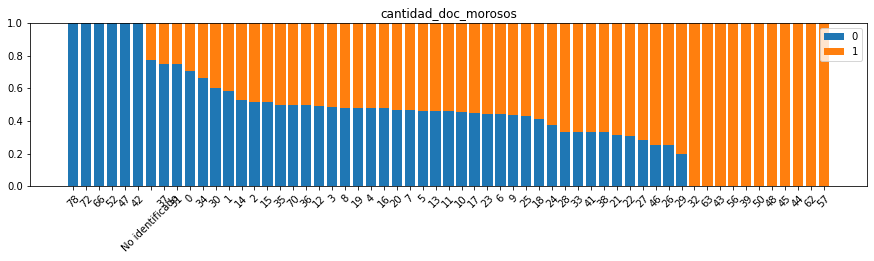

In [156]:

printBarrasApiladas(df, 'cantidad_doc_morosos', normalize=True)

In [26]:
def notNullRelation(dfTmp , listColumn):
    dfTmp = dfTmp[listColumn].notna().astype(int)
    num = 1
    dfTmp['sum'] = 0
    for item in dfTmp.drop('sum', axis = 1):
        print(item)
        print(num)
        dfTmp[item] = dfTmp[item]*num
        dfTmp['sum'] = dfTmp['sum'] + dfTmp[item]
        num = num*10
    dfTmp = dfTmp.reset_index()
    print('---------------')
    print(dfTmp['sum'].value_counts())

In [102]:
deudaList = ['esta_reportado_mes00', 'esta_reportado_mes01', 'esta_reportado_mes02', 'esta_reportado_mes03', 'esta_reportado_mes04', 'esta_reportado_mes05']
notNullRelation(df , deudaList)

esta_reportado_mes00
1
esta_reportado_mes01
10
esta_reportado_mes02
100
esta_reportado_mes03
1000
esta_reportado_mes04
10000
esta_reportado_mes05
100000
---------------
111111    488077
Name: sum, dtype: int64
